In [1]:
import sys
#sys.path.append('C:/Users/Fabian/Documents/gempy')
sys.path.insert(0, '/home/bl9/gempy')
import gempy as gp

%matplotlib inline
import pymc
import numpy as np
import math

from IPython.core.display import Image

from pymc.Matplot import plot
from pymc import graph

from IPython.core.pylabtools import figsize
figsize(15, 6)

import scipy.optimize as sop
import scipy.stats as stats
from scipy.signal import argrelextrema

import matplotlib.mlab as mlab
from matplotlib import pyplot as plt

import importlib

from operator import itemgetter

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import vtk
import evtk

from scipy.interpolate import griddata

import decision_making as dm

from skimage import measure

import scipy.signal as sg

/home/bl9/gempy/gempy/plotting/visualization.py:36: UserWarning: Steno 3D package is not installed. No 3D online visualization available.
  warnings.warn('Steno 3D package is not installed. No 3D online visualization available.')


In [2]:
# Importing the data from csv files and setting extent and resolution
geo_data = gp.create_data([0,1000,0,1000,0,1000],[50,50,50],
                         path_o = ".././input_data/simple_dome_orientations1.csv",
                         path_i = ".././input_data/simple_dome_points1.csv")
geo_data.n_faults = 0

In [3]:
gp.set_series(geo_data, {"Dome":('Shale')},
                       order_series = ["Dome",], order_formations=['Shale',])

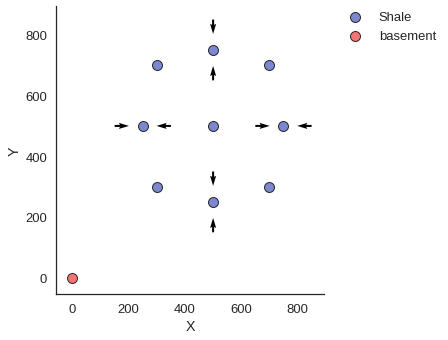

In [4]:
figsize(20,10)
gp.plotting.plot_data(geo_data,direction='z')

In [5]:
# Groups considering top view on spill line:
# From A to H clockwise, starting at center left
# Central points are a separate group (nan)

geo_data.interfaces['group_id']

0    0.0
1    1.0
2    2.0
3    3.0
4    4.0
5    5.0
6    6.0
7    7.0
8    NaN
9    NaN
Name: group_id, dtype: float64

In [6]:
interp_data = gp.InterpolatorData(geo_data,u_grade=[3],
                                  output='gradients', dtype='float64', compile_theano=True)

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0


In [7]:
lith_sol, fault_sol = gp.compute_model(interp_data)

In [8]:
base_n = int(geo_data.formations.loc['basement','formation_number'].values[0])
#sandstone_n = int(geo_data.formations.loc['Sandstone','formation_number'].values[0])
shale_n = int(geo_data.formations.loc['Shale','formation_number'].values[0])

In [9]:
#sst_surf_v, sst_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], n_formation = sandstone_n)
shale_surf_v, shale_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], n_formation = shale_n)

In [10]:
# DECLARING SOME MODEL VARIABLES
resolution = geo_data.resolution[1] #resolution, standard: 50
model_size = geo_data.extent[:2][1] # 'real' model extent, here: 2000 m - cubic (what if not cubic?)
scale_factor = (model_size/resolution) # scale factor used for calculating voxel volumes in [m]
                                        # here: 2000/50 = 40
rescale_f = interp_data.rescaling_factor # rescaling factor from geo_data to interp_data

minmax_buffer = True # buffer around local min and max values [on/off] - not used atm

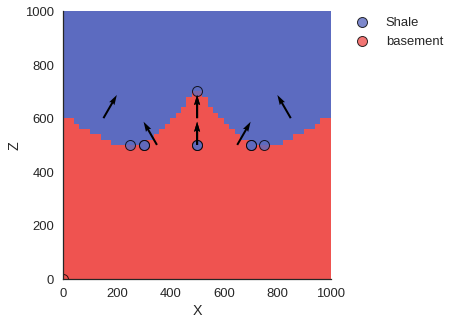

In [11]:
%matplotlib inline
figsize(20,10)
gp.plotting.plot_section(geo_data, lith_sol[0], int(resolution/2), plot_data=1, direction='y')

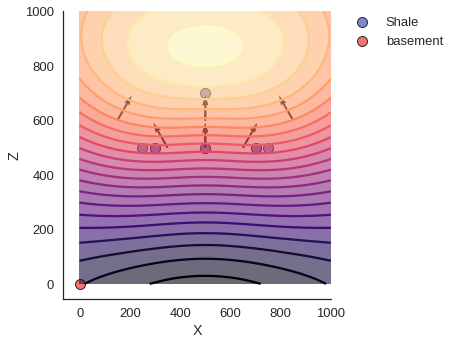

In [12]:
%matplotlib inline
figsize(20,10)
gp.plotting.plot_scalar_field(geo_data, lith_sol[1], 
                              0,
                              plot_data=1, direction='y')

In [13]:
importlib.reload(np)
a = np.zeros_like(lith_sol[3])

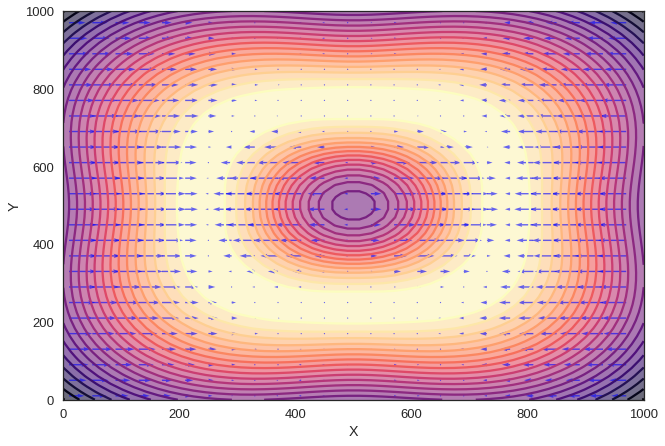

In [14]:
gp.plot_gradient(geo_data, lith_sol[1], lith_sol[2], a, lith_sol[4], 
                 cell_number=25, direction='z', quiver_stepsize=2)

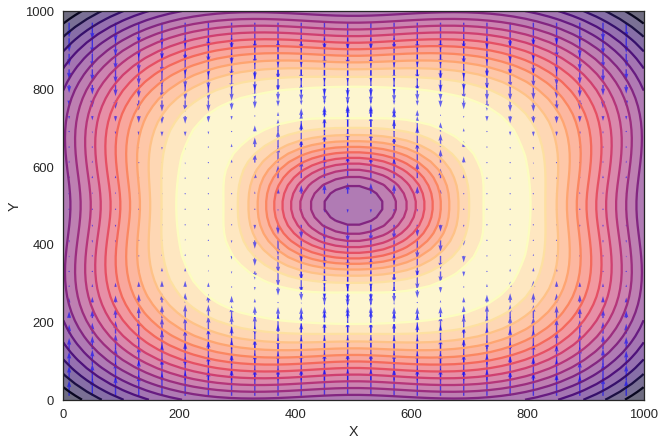

In [15]:
gp.plot_gradient(geo_data, lith_sol[1], a, lith_sol[3], lith_sol[4], 
                 cell_number=26, direction='z', quiver_stepsize=2)

In [16]:
gx = lith_sol[2].reshape(resolution,resolution,resolution)
gy = lith_sol[3].reshape(resolution,resolution,resolution)
gz = lith_sol[4].reshape(resolution,resolution,resolution)

In [63]:
v_gx0, s_gx, n_gx, val_gx = measure.marching_cubes_lewiner(gx, 0)

In [64]:
v_gy0, s_gy, n_gy, val_gy = measure.marching_cubes_lewiner(gy, 0)

In [65]:
v_gx0.shape, v_gy0.shape

((10622, 3), (10624, 3))

In [66]:
# scaling voxels up to meters
v_gx = v_gx0 * (geo_data.extent[1]/resolution)
v_gy = v_gy0 * (geo_data.extent[3]/resolution)

In [67]:
v_gx

array([[  1.87617416e+01,   0.00000000e+00,   2.00000000e+02],
       [  2.00000000e+01,   2.00000000e+01,   1.91248108e+02],
       [  2.00000000e+01,   4.95744944e-01,   2.00000000e+02],
       ..., 
       [  9.80000000e+02,   9.60000000e+02,   1.87920319e+02],
       [  9.61103760e+02,   9.80000000e+02,   2.00000000e+02],
       [  9.80000000e+02,   9.80000000e+02,   1.96540283e+02]], dtype=float32)

In [68]:
from scipy.spatial import distance

In [69]:
dist_gxy = distance.cdist(v_gx,v_gy, 'euclidean')

In [70]:
mean_dist_gx = np.mean(dist_gxy, axis=1)
mean_dist_gy = np.mean(dist_gxy, axis=0)

In [71]:
dist_gxy.shape

(10622, 10624)

In [72]:
minx = np.min(dist_gxy, axis=1)
miny = np.min(dist_gxy, axis=0)

In [73]:
print('gx min distance:', np.min(np.min(dist_gxy, axis=1)))
print('gy min distance:', np.min(np.min(dist_gxy, axis=0)))

gx min distance: 0.00251770019531
gy min distance: 0.00251770019531


In [85]:
gx_cut_bool = minx < 20
gy_cut_bool = miny < 20

In [86]:
v_gx[gx_cut_bool]

array([[  1.87617416e+01,   0.00000000e+00,   2.00000000e+02],
       [  2.00000000e+01,   2.00000000e+01,   1.91248108e+02],
       [  2.00000000e+01,   4.95744944e-01,   2.00000000e+02],
       ..., 
       [  9.80000000e+02,   9.60000000e+02,   1.87920319e+02],
       [  9.61103760e+02,   9.80000000e+02,   2.00000000e+02],
       [  9.80000000e+02,   9.80000000e+02,   1.96540283e+02]], dtype=float32)

In [87]:
v_gy[gy_cut_bool]

array([[  1.63505211e-01,   2.00000000e+01,   2.00000000e+02],
       [  0.00000000e+00,   0.00000000e+00,   1.96422089e+02],
       [  0.00000000e+00,   1.95910931e+01,   2.00000000e+02],
       ..., 
       [  9.80000000e+02,   9.60000000e+02,   2.00187042e+02],
       [  9.80000000e+02,   9.61033203e+02,   2.00000000e+02],
       [  9.80000000e+02,   9.80000000e+02,   1.96528610e+02]], dtype=float32)

In [88]:
vgx_cut = v_gx[gx_cut_bool]
vgy_cut = v_gy[gy_cut_bool]

In [89]:
vgx_cut.shape

(3462, 3)

In [90]:
vgy_cut.shape

(3466, 3)

In [91]:
vgx_cut[-1]

array([ 980.       ,  980.       ,  196.5402832], dtype=float32)

In [92]:
vgy_cut[-1]

array([ 980.        ,  980.        ,  196.52861023], dtype=float32)

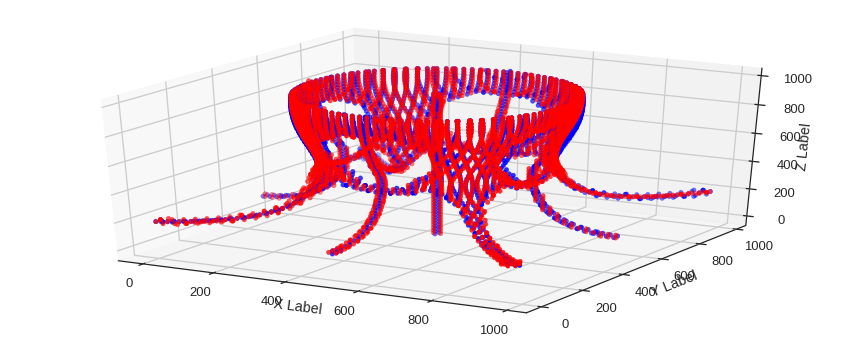

In [93]:
%matplotlib inline
figsize(15,6)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(vgx_cut[:,0],vgx_cut[:,1],vgx_cut[:,2], color='b')
ax.scatter(vgy_cut[:,0],vgy_cut[:,1],vgy_cut[:,2], color='r')
    
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

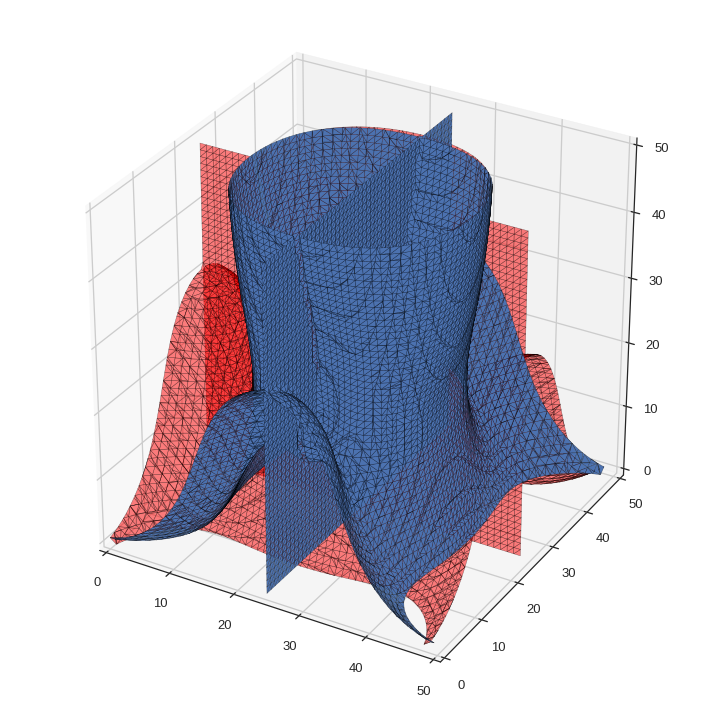

In [164]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces], alpha=0.5)
mesh.set_edgecolor('k')

mesh2 = Poly3DCollection(verts2[faces2], alpha=0.5)
mesh2.set_edgecolor('k')
mesh2.set_facecolor('r')
ax.add_collection3d(mesh2)
ax.add_collection3d(mesh)

#ax.set_xlabel("x-axis: a = 6 per ellipsoid")
#ax.set_ylabel("y-axis: b = 10")
#ax.set_zlabel("z-axis: c = 16")

ax.set_xlim(0, 50)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 50)  # b = 10
ax.set_zlim(0, 50)  # c = 16

plt.tight_layout()
plt.show()


In [94]:
v_layer,s_layer = gp.get_surfaces(interp_data, lith_sol[1])

In [105]:
v_l = np.array(v_layer[0])

In [119]:
lmin_dist = distance.cdist(vgx_cut, v_l)

In [120]:
min_dist = np.min(lmin_dist, axis=0)
l_cut_bool = min_dist < 20
intersect = v_l[l_cut_bool]

In [121]:
lmin_disty = distance.cdist(vgy_cut, v_l)
min_disty = np.min(lmin_disty, axis=0)
l_cut_booly = min_disty < 20
intersect_y = v_l[l_cut_booly]

In [122]:
intersect.shape

(144, 3)

In [124]:
np.max(intersect[:,2])

684.43466186523426

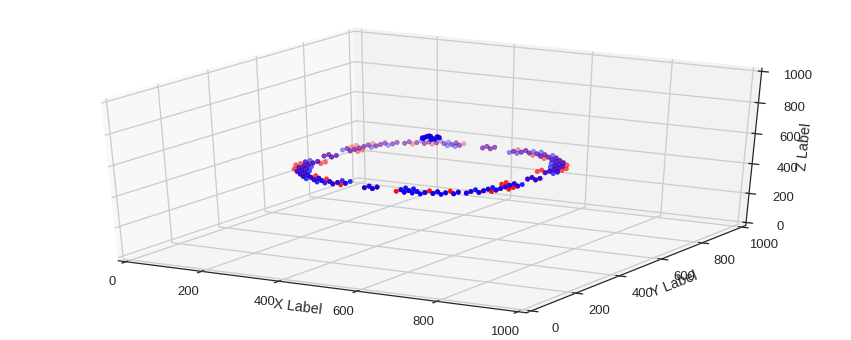

In [123]:
figsize(15,6)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(intersect[:,0],intersect[:,1],intersect[:,2], color='b')
ax.scatter(intersect_y[:,0],intersect_y[:,1],intersect_y[:,2], color='r')

ax.set_xlim(0,1000)
ax.set_ylim(0,1000)
ax.set_zlim(0,1000)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [82]:
gx[:,25,25]

array([ 0.41763756,  0.42365652,  0.4288398 ,  0.43321466,  0.43691942,
        0.44040465,  0.44474214,  0.43928599,  0.36291811,  0.24375789,
        0.11790247, -0.00709809, -0.12771486, -0.24047728, -0.34168845,
       -0.4274056 , -0.49296224, -0.53287649, -0.5426203 , -0.5211156 ,
       -0.47071323, -0.39523271, -0.29886127, -0.18632802, -0.063377  ,
        0.06319764,  0.18615241,  0.29869327,  0.39507616,  0.47057125,
        0.5209893 ,  0.54250729,  0.53277051,  0.49285603,  0.42729574,
        0.34157714,  0.24037074,  0.12762013,  0.00702057, -0.11796004,
       -0.24379498, -0.36293581, -0.43928853, -0.44473714, -0.4403947 ,
       -0.43690541, -0.43319741, -0.42881992, -0.42363453, -0.41761383])

In [83]:
gy[:,25,25]

array([ 0.00523339,  0.00610546,  0.00718641,  0.00855089,  0.01031542,
        0.01261687,  0.01491829,  0.0097414 , -0.00412767, -0.00941104,
       -0.00999336, -0.00850099, -0.00568272, -0.00177346,  0.00313468,
        0.00901311,  0.01585417,  0.02353134,  0.03164192,  0.0395924 ,
        0.04686026,  0.05309382,  0.05804319,  0.06149587,  0.06327537,
        0.0632771 ,  0.06150098,  0.05805147,  0.05310491,  0.04687366,
        0.03960747,  0.03165795,  0.02354781,  0.01587101,  0.00903063,
        0.0031532 , -0.00175391, -0.00566239, -0.00848036, -0.00997295,
       -0.00939133, -0.00410921,  0.00975775,  0.01493292,  0.0126305 ,
        0.01032818,  0.00856283,  0.00719757,  0.0061159 ,  0.00524315])

In [71]:
g_xy= gx+gy

In [70]:
gx()

array([[[ -6.28678640e-03,   2.16998649e-03,   1.08298864e-02, ...,
           2.67996907e-01,   2.64674962e-01,   2.60989994e-01],
        [  1.75850364e-04,   9.05932300e-03,   1.81533545e-02, ...,
           2.78135955e-01,   2.74395853e-01,   2.70295292e-01],
        [  6.64519100e-03,   1.59608908e-02,   2.54950952e-02, ...,
           2.87790716e-01,   2.83618361e-01,   2.79090345e-01],
        ..., 
        [  6.64517982e-03,   1.59608778e-02,   2.54950821e-02, ...,
           2.87790716e-01,   2.83618361e-01,   2.79090345e-01],
        [  1.75839348e-04,   9.05931182e-03,   1.81533415e-02, ...,
           2.78135955e-01,   2.74395853e-01,   2.70295292e-01],
        [ -6.28679711e-03,   2.16997485e-03,   1.08298734e-02, ...,
           2.67996877e-01,   2.64674932e-01,   2.60989964e-01]],

       [[ -8.48814100e-03,  -2.22331102e-04,   8.24683905e-03, ...,
           2.61091053e-01,   2.57733583e-01,   2.54021555e-01],
        [ -1.98278646e-03,   6.71765860e-03,   1.56294797e-0

In [62]:
min_x_pos = sg.argrelmin(np.abs(gx))
min_y_pos = sg.argrelmin(np.abs(gy))
min_z_pos = sg.argrelmin(np.abs(gz))

min_z_bool = np.zeros_like(gz)
min_z_bool[min_z_pos] = 1

In [60]:
min_x_pos.shape

(6536,)

In [58]:
min_x_pos.shape

AttributeError: 'tuple' object has no attribute 'shape'

In [43]:
min_z_pos.shape

(2623,)

In [97]:
interp_data.th_fn()

ValueError: Bad input argument to theano function with name "/home/bl9/gempy/gempy/interpolator.py:148" at index 0 (0-based).  
Backtrace when that variable is created:

  File "/home/bl9/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/bl9/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/bl9/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-6d40a1b2f81b>", line 2, in <module>
    output='gradients', dtype='float64', compile_theano=True)
  File "/home/bl9/gempy/gempy/interpolator.py", line 92, in __init__
    self.interpolator = self.InterpolatorTheano(self, output=output, theano_optimizer=theano_optimizer, **kwargs)
  File "/home/bl9/gempy/gempy/interpolator.py", line 360, in __init__
    self.create_theano_graph(**kwargs)
  File "/home/bl9/gempy/gempy/interpolator.py", line 430, in create_theano_graph
    verbose=self.verbose)
  File "/home/bl9/gempy/gempy/theano_graph.py", line 131, in __init__
    self.dips_position_all = T.matrix("Position of the dips")
could not convert string to float: 'Gx'

In [ ]:
def spill_leak_P(interp_data, res_surf, lith, fault_presence = geo_data.n_faults, print_figures=True):    
    
    # creating a grid with uniform distances for vertices of the reservoir surface
    grid_x, grid_y = np.meshgrid(np.unique(interp_data.geo_data_res.grid.values[:, 0]),
                             np.unique(interp_data.geo_data_res.grid.values[:, 1]))

    #grid_x=(grid_x*rescale_f)-(np.min(grid_x)*rescale_f)
    #grid_y=(grid_y*rescale_f)-(np.min(grid_y)*rescale_f)
    grid_x=(grid_x)-(np.min(grid_x))
    grid_y=(grid_y)-(np.min(grid_y))
    
    grid_z0 = griddata(res_surf[:,:2], res_surf[:,2],
                       (grid_x, grid_y), method='linear')
    
    # order of values that serve to find relative extrema (min/max)
    rel_order_maxX = 5
    rel_order_maxY = 10
    rel_order_minX = 5
    rel_order_minY = 5
    
    # check grid_z0 for max and min in directions x and y
    # direction X
    minX1,minX2 = argrelextrema(grid_z0,np.less,order=rel_order_minX,axis=1)
    maxX1,maxX2 = argrelextrema(grid_z0,np.greater,order=rel_order_maxX,axis=1)
    grid_minX = np.zeros_like(grid_z0)
    grid_minX[minX1,minX2]=1           # grid of min in X
    grid_maxX = np.zeros_like(grid_z0)
    grid_maxX[maxX1,maxX2]=1           # grid of max in X
    
    #direction Y
    minY1,minY2 = argrelextrema(grid_z0,np.less,order=rel_order_minY,axis=0)
    maxY1,maxY2 = argrelextrema(grid_z0,np.greater,order=rel_order_maxY,axis=0)
    grid_minY = np.zeros_like(grid_z0)
    grid_minY[minY1,minY2]=1           # grid of min in Y
    grid_maxY = np.zeros_like(grid_z0)
    grid_maxY[maxY1,maxY2]=1           # grid of max in Y
    
    # fault leak line: defining line of juxtaposition, point of cross-fault leakage to be found on it
    # check for minima line that is on hanging wall side compared to max contact of layer top with fault
    fault_max_line_bool = np.copy(grid_maxX)
    fault_max_line = fault_max_line_bool.argmax(axis=1)
    fault_max = np.max(fault_max_line) # max of fault-layer contact as threshold        
    fleak_line = np.copy(grid_minX).astype(int)
    fleak_line[:,fault_max:]=0 # only returns minima at hanging wall side
    
    # minmax buffering
    # to set neighboring values of min and max to min and max respectively, too 
    if minmax_buffer:
        minXroll1 = np.logical_or(grid_minX,np.roll(grid_minX,1, axis=0))
        minXroll1[:,:fault_max] = 0
        minXroll2 = np.logical_or(grid_minX,np.roll(grid_minX,-1, axis=0))
        minXroll2[:,:fault_max] = 0
        minXbuffer = np.logical_or(minXroll1, minXroll2)
        grid_minX = np.logical_or(grid_minX, minXbuffer)
        #grid_maxX = np.logical_or(grid_maxX,np.roll(grid_maxX,1))
        #grid_maxX = np.logical_or(grid_maxX,np.roll(grid_maxX,-1))
        #grid_minY = np.logical_or(grid_minY,np.roll(grid_minY,1))
        #grid_minY = np.logical_or(grid_minY,np.roll(grid_minY,-1))
        grid_maxY = np.logical_or(grid_maxY,np.roll(grid_maxY,1, axis=1))
        grid_maxY = np.logical_or(grid_maxY,np.roll(grid_maxY,-1, axis=1))
    
    #check for saddle points
    saddle_p1 = np.logical_and(grid_minX,grid_maxY)
    saddle_p2 = np.logical_and(grid_minY,grid_maxX)
    saddle_p_all= np.logical_or(saddle_p1, saddle_p2)
    
    # this should find saddle points relative to X and Y directions
    # problem of finding other points in a rotated direction?
    ### NOT FINISHED: DEFINE LEAK POINT OVER LEAK LINE MAX?
    
    if fault_presence == 0:
        pot_spill_points = saddle_p_all
        
        pot_spill_Xcoord = grid_x[pot_spill_points]
        pot_spill_Ycoord = grid_y[pot_spill_points]
        pot_spill_Zcoord = grid_z0[pot_spill_points]    
        pot_spill_3Dcoord = np.array(list(zip(pot_spill_Xcoord, pot_spill_Ycoord, pot_spill_Zcoord)))
        
        if pot_spill_3Dcoord.size == 0:
            anticline_spill_3Dcoord = np.array([]) # if no leak coordinates found, set to empty array
        else:
            max_spill_pos = pot_spill_3Dcoord[:,2].argmax(axis=0)
            anticline_spill_3Dcoord = pot_spill_3Dcoord[max_spill_pos,:]
            
        if print_figures==True:
            figsize(15,6)
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            #ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
            ax.scatter(grid_x, grid_y, grid_minY, c="b", alpha = 0.1)
            ax.scatter(grid_x, grid_y, grid_maxY, c="r", alpha = 0.1)
            ax.scatter(grid_x, grid_y, grid_minX, c="b", alpha = 0.1)
            ax.scatter(grid_x, grid_y, grid_maxX, c="r", alpha = 0.1)
            ax.scatter(grid_x, grid_y, pot_spill_points, c="black", alpha = 1, marker='x', s = 250)
            #ax.scatter(grid_x, grid_y, pot_leak_points, c="black", alpha = 1, marker='+', s = 250)
            ax.scatter(grid_x, grid_y, fleak_line, c="b", alpha = 1, marker='+', s= 250)
            #ax.scatter(grid_x, grid_y, leak_max[2], c="g", alpha = 1, marker='+', s= 250)
            
            ax.set_xlabel('X Label')
            ax.set_ylabel('Y Label')
            ax.set_zlabel('Z Label')
            
            plt.show()
        
            # plot of reservoir top surface and position of all potential LPs(+) and SPs(x):
            fault_leak_3Dcoord = np.nan
            plot_spill_leak(res_surf, pot_spill_points, anticline_spill_3Dcoord, 
                            fault_leak_3Dcoord, grid_x, grid_y, grid_z0)
        
        return anticline_spill_3Dcoord, np.nan
    
    else:          
    
        # distinguish anticlinal spill points from fault leak points:
        pot_leak_points = np.logical_and(fleak_line,saddle_p_all)    
        pot_spill_points = saddle_p_all - pot_leak_points   # substracting leak bool from saddle point bool 
                                                            # to get spill point bool    
        # leak and spill point 3D coordinates
        # LEAK POINT
        pot_leak_Xcoord = grid_x[pot_leak_points]
        pot_leak_Ycoord = grid_y[pot_leak_points]
        pot_leak_Zcoord = grid_z0[pot_leak_points]    
        pot_leak_3Dcoord = np.array(list(zip(pot_leak_Xcoord, pot_leak_Ycoord, pot_leak_Zcoord)))
            
        if pot_leak_3Dcoord.size == 0:
            fault_leak_3Dcoord = np.array([]) # if no leak coordinates found, set to empty array
        else:
            max_leak_pos = pot_leak_3Dcoord[:,2].argmax(axis=0)
            fault_leak_3Dcoord = pot_leak_3Dcoord[max_leak_pos,:] # max is LP
            
        # SPILL POINT
        pot_spill_Xcoord = grid_x[pot_spill_points]
        pot_spill_Ycoord = grid_y[pot_spill_points]
        pot_spill_Zcoord = grid_z0[pot_spill_points]    
        pot_spill_3Dcoord = np.array(list(zip(pot_spill_Xcoord, pot_spill_Ycoord, pot_spill_Zcoord)))
        
        if pot_spill_3Dcoord.size == 0:
            anticline_spill_3Dcoord = np.array([]) # if no leak coordinates found, set to empty array
        else:
            max_spill_pos = pot_spill_3Dcoord[:,2].argmax(axis=0)
            anticline_spill_3Dcoord = pot_spill_3Dcoord[max_spill_pos,:] # max is SP
        
        # PLOTTING (for visualization and checking)
        # plot of min/max bools and all potential LPs(+) and SPs(x):
        if print_figures==True:
            figsize(15,6)
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            #ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
            ax.scatter(grid_x, grid_y, grid_minY, c="b", alpha = 0.1)
            ax.scatter(grid_x, grid_y, grid_maxY, c="r", alpha = 0.1)
            ax.scatter(grid_x, grid_y, grid_minX, c="b", alpha = 0.1)
            ax.scatter(grid_x, grid_y, grid_maxX, c="r", alpha = 0.1)
            ax.scatter(grid_x, grid_y, pot_spill_points, c="black", alpha = 1, marker='x', s = 250)
            ax.scatter(grid_x, grid_y, pot_leak_points, c="black", alpha = 1, marker='+', s = 250)
            #ax.scatter(grid_x, grid_y, fleak_line, c="b", alpha = 1, marker='+', s= 250)
            #ax.scatter(grid_x, grid_y, leak_max[2], c="g", alpha = 1, marker='+', s= 250)
            
            ax.set_xlabel('X Label')
            ax.set_ylabel('Y Label')
            ax.set_zlabel('Z Label')
            
            plt.show()
        
            # plot of reservoir top surface and position of all potential LPs(+) and SPs(x):
            plot_spill_leak(res_surf, pot_spill_points, anticline_spill_3Dcoord, fault_leak_3Dcoord, grid_x, grid_y, grid_z0)
        
        return anticline_spill_3Dcoord, fault_leak_3Dcoord

def plot_spill_leak(res_surface, pot_spills, spill_point, leak_point, grid_x, grid_y, grid_z0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
    #ax.scatter(grid_x, grid_y,pot_spills, c="r", alpha = 1, marker='p', s = 250)
    if spill_point.size != 0:        
        ax.scatter(spill_point[0],spill_point[1],spill_point[2], c="black", alpha = 1, marker='x', s = 250)
    if leak_point.size != 0:     
        ax.scatter(leak_point[0],leak_point[1],leak_point[2], c="black", alpha = 1, marker='+', s = 250)
        
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()

In [ ]:
def rotate_dome(orig_v, roll_n, unc_z):
    #roll array of z-values so that 'start' is at [0]
    circle_z = np.roll(orig_v, -roll_n)
    circle_z[0] = orig_v[0] + unc_z
    circle_z[1] = orig_v[1] + (unc_z/2)
    circle_z[2] = orig_v[2]
    circle_z[3] = orig_v[3] - (unc_z/2)
    circle_z[4] = orig_v[4] - unc_z
    circle_z[5] = orig_v[5] - (unc_z/2)
    circle_z[6] = orig_v[6] 
    circle_z[7] = orig_v[7] + (unc_z/2)
    changed_z = np.roll(circle_z, roll_n)
    return changed_z

In [ ]:
# SAVING ORIGINAL Z-VALUES (so they are not overwritten and can be used a base for every iteration)    

original_values = interp_data.geo_data_res.interfaces.loc[0:7,'Z']

# SETTING Z-UNCERTAINTIES FOR EACH LAYER TOP
unc_f = 1
std_unc = 30 #* unc_f

z_unc = pymc.Normal('z_unc', 0, 1./np.square(std_unc/rescale_f))

#start_unc = np.random.randint(8)

Variation by: -12.4583338497
Start at point: 4


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:116: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


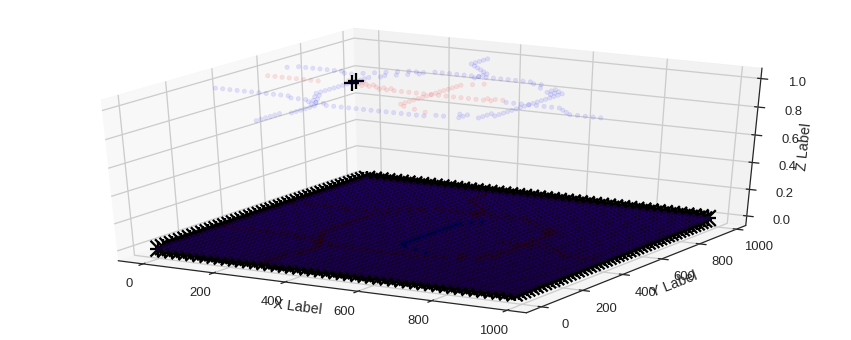

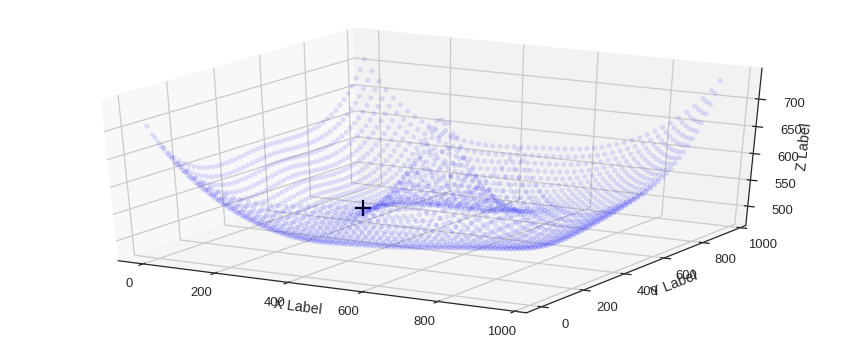

[] [ 240.          540.          500.36207581]


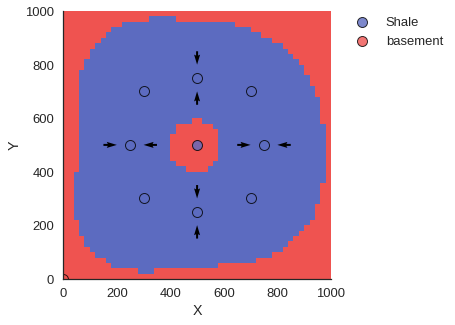

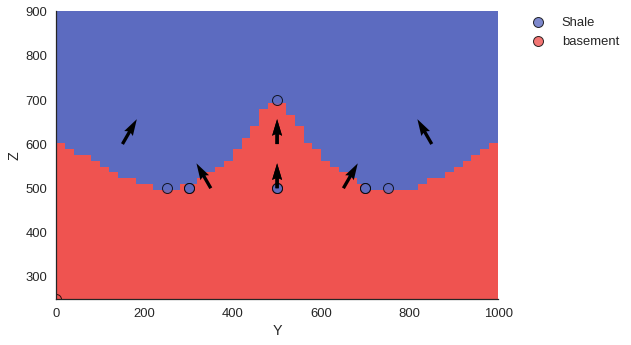

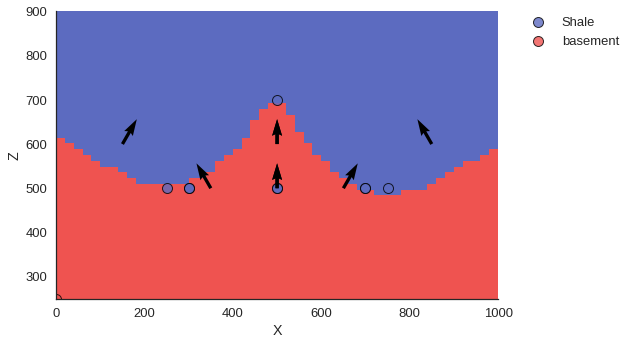

In [ ]:
@pymc.deterministic
def interp_unc(value=0, z_unc=z_unc, original_values=original_values):
    
    print('Variation by:', z_unc*rescale_f)
    
    ### Declare on the the points on the contour closure (circle) to be
    ### assigned the starting uncertainty
    ### (COULD ALSO MAKE THIS TO DEPEND ON ITER TO CONTROL)
    start = 3#np.random.randint(8)
    print('Start at point:', start+1)
    #start_bool = interp_data.geo_data_res.interfaces['group_id'] == start
    #start_point = interp_data.geo_data_res.interfaces[start]
    
    #point_range = len(original_values)
    
    # change z_values on circle contour based on uncertainty variation
    changed_values = rotate_dome(original_values, start, z_unc)     
    
    # insert new changed values into interp_data
    interp_data.geo_data_res.interfaces.loc[0:7,'Z'] = changed_values
   
    return interp_data

@pymc.deterministic
def structural_model(interp_data_M=interp_unc, shale_n=shale_n, print_figures=True):
    lith_sol, fault_sol = gp.compute_model(interp_data_M)
    lith_block = lith_sol[0]
    
    #fault_block = fault_sol[0]  
    shale_surf_v, shale_surf_s = gp.get_surfaces(\
        interp_data = interp_data_M, potential_lith=lith_sol[1], n_formation = shale_n)
    #max_vol, trap, SSF, trap_control = max_trap_vol(interp_data_M, lith_block, fault_block, seal_surf_v, seal_th)
    #print("Maximum trap volume: %s m³" % max_vol)
    a_spill, f_leak = spill_leak_P(interp_data_M, shale_surf_v, lith_block, print_figures)
    print(a_spill, f_leak)
    
    if print_figures:
        plt.figure(1)
        gp.plotting.plot_section(geo_data, lith_sol[0], 
                                 int(resolution/2), plot_data =1, direction='z')
        plt.figure(2)
        gp.plotting.plot_section(geo_data, lith_sol[0], 
                                 int(resolution/2), plot_data =1, direction='x')
        plt.figure(3)
        gp.plotting.plot_section(geo_data, lith_sol[0], 
                                 int(resolution/2), plot_data =1, direction='y')
        #gp.plotting.plot_section(geo_data, trap, int(resolution/2), plot_data =0)
    return lith_sol#, fault_sol, max_vol, trap, SSF, trap_control


In [ ]:
iterations = 5
model = pymc.Model([interp_unc, z_unc, structural_model])

Variation by: 40.6459568917
Start at point: 4


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:116: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


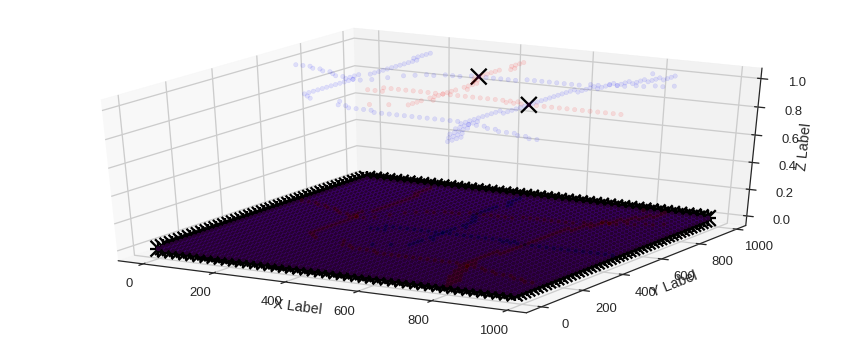

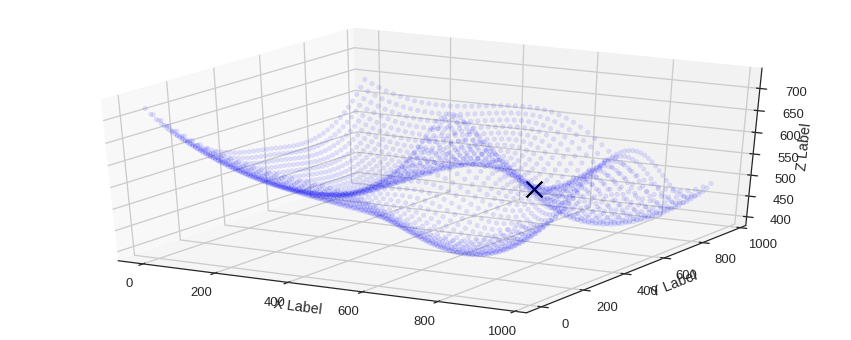

[ 740.          480.          532.30003548] []
 [---------------  40%                  ] 2 of 5 complete in 7.0 secVariation by: -23.631514243
Start at point: 4


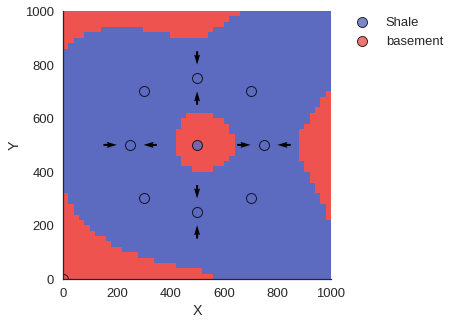

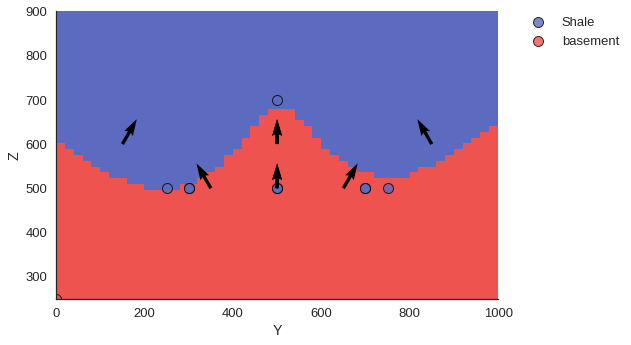

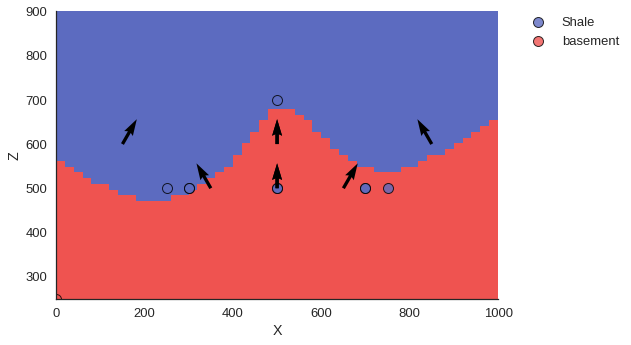

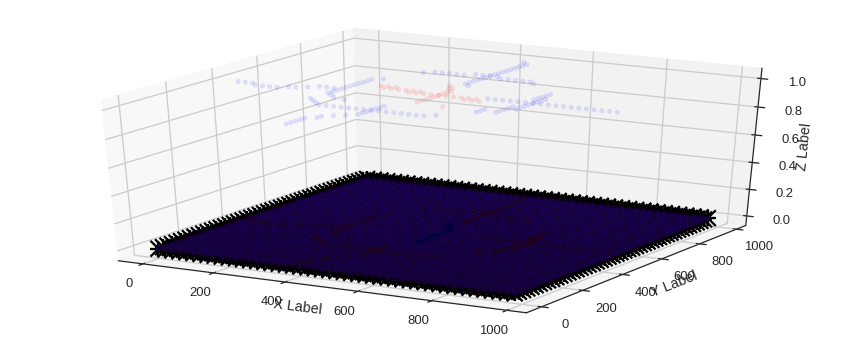

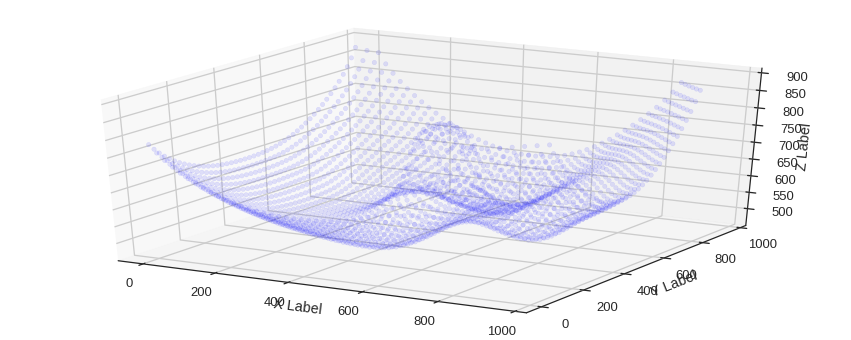

[] []
 [-----------------60%--                ] 3 of 5 complete in 14.4 secVariation by: -62.0131595539
Start at point: 4


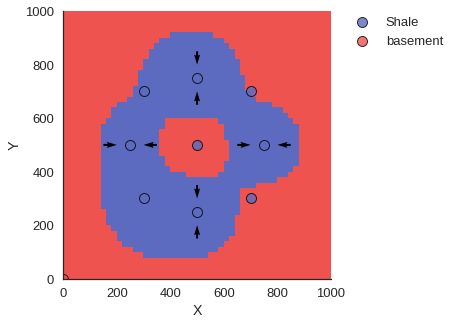

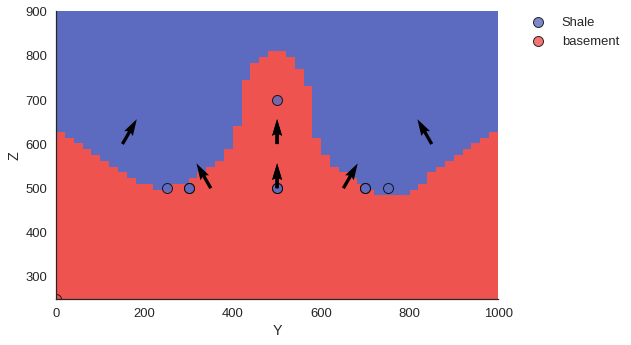

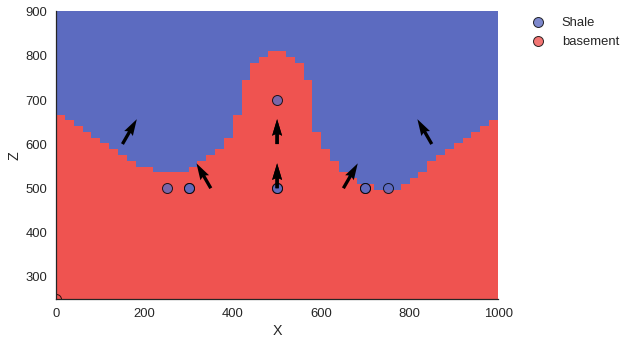

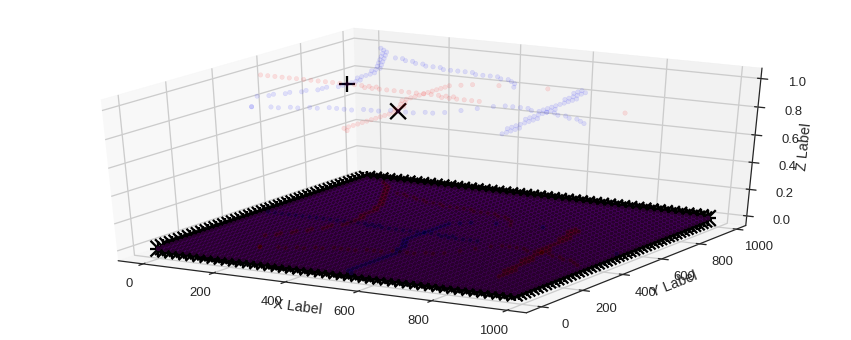

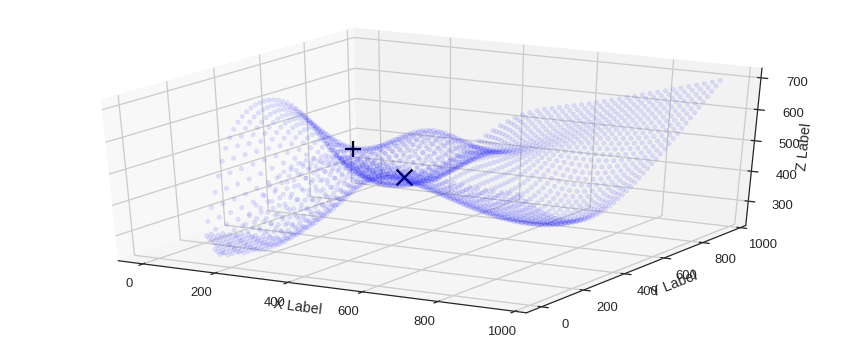

[ 520.          260.          494.80792618] [ 240.          500.          491.31703758]
 [-----------------80%----------        ] 4 of 5 complete in 21.6 secVariation by: 23.157137365
Start at point: 4


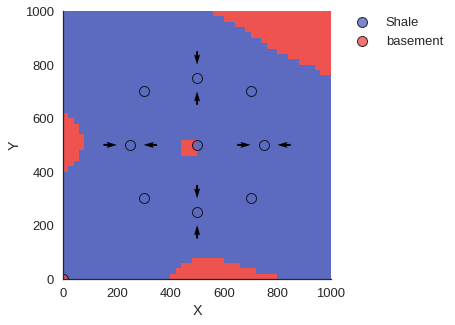

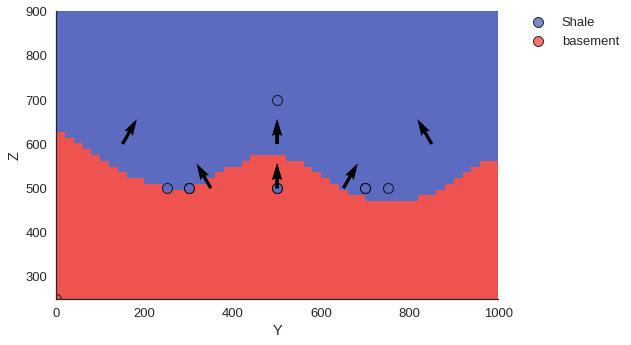

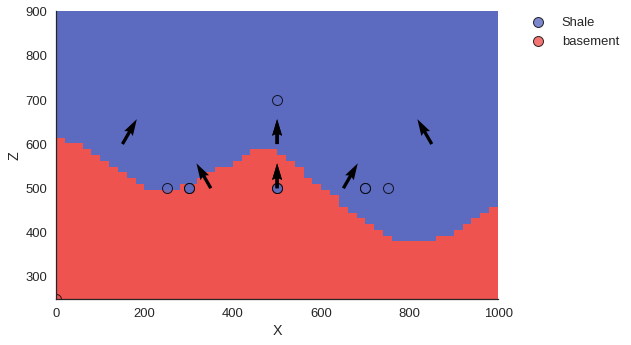

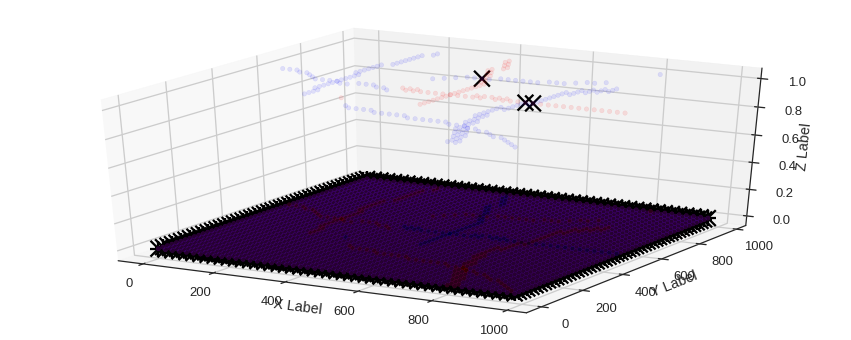

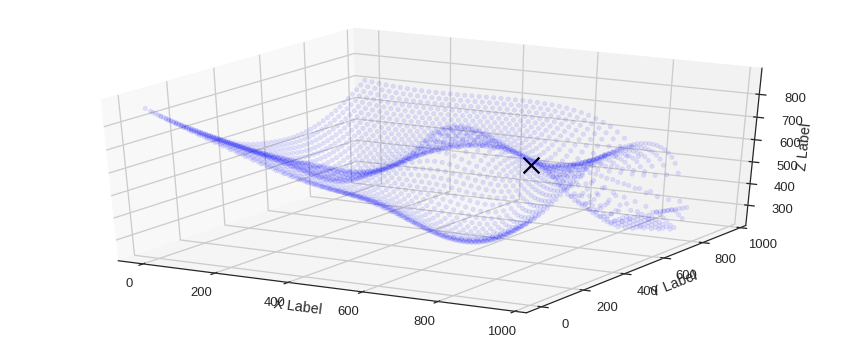

[ 720.          500.          596.83437538] []
 [-----------------100%-----------------] 5 of 5 complete in 29.1 secVariation by: -29.6269237573
Start at point: 4


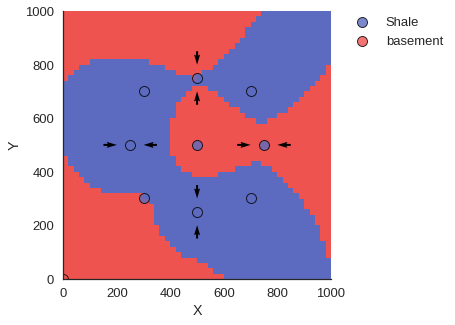

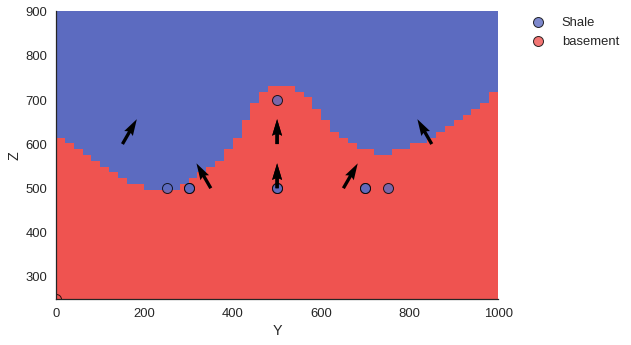

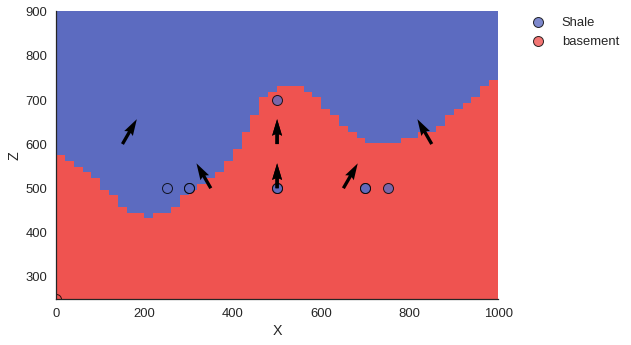

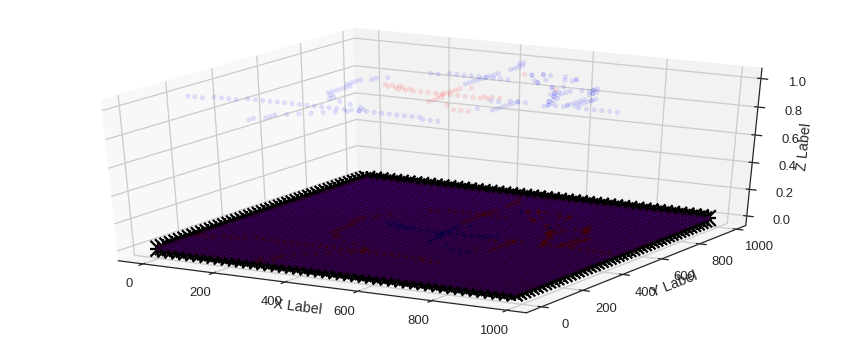

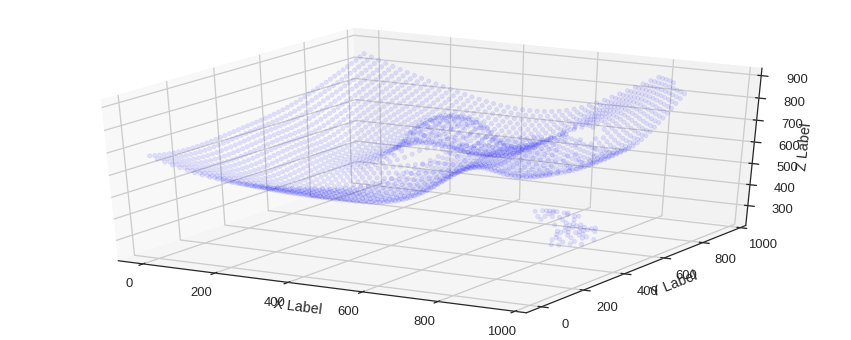

[] []
 [--------------------120%---------------------] 6 of 5 complete in 36.3 sec

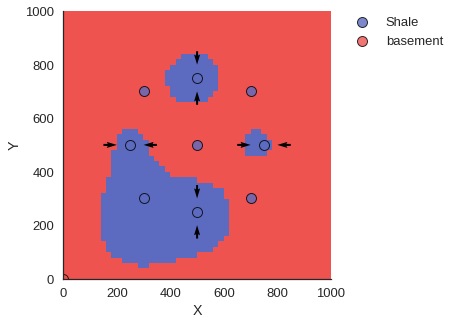

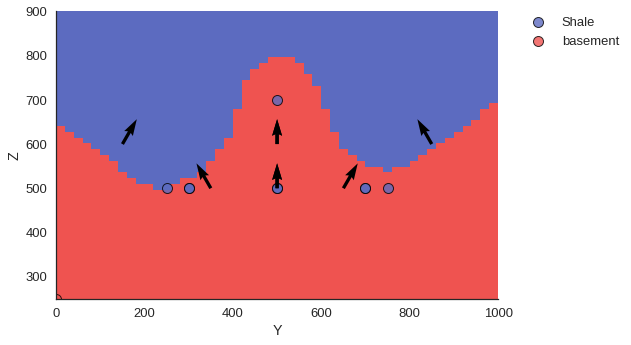

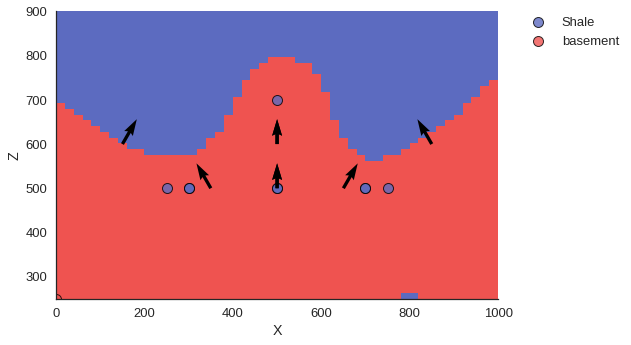

In [ ]:
M = pymc.MCMC(model)
#M = pymc.MCMC(model,db= "hdf5" , dbname= "D:/PyMC_DataBase/prior_model_noBlocks_SSFc_3_1000iter_2017_11_12")
M.sample(iter=iterations)

In [ ]:
#for i in range(8):
#    itp_d = interp_unc(z_unc=30, original_values=original_values,start=i)
#    structural_model(interp_data_M=itp_d, shale_n=shale_n, print_figures=True)